<a href="https://colab.research.google.com/github/alexweltgeist/twitter_bitcoin/blob/main/Sentiment_Analysis_with_CNN_v03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textsearch
import nltk
nltk.download('punkt')

     |████████████████████████████████| 327kB 31.4MB/s 
     |████████████████████████████████| 286kB 45.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85400 sha256=c9c1993c25f76b8385848d9a1ebffa440cb691926b6e8fb8833c7dba677a0497
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/all_tweets_with_lable.csv', sep=',', header = 0)
dataset = dataset[dataset['lable'] != 'Neutral']
dataset.head()
#dataset.count()

,text,lable
0,Perspective. And sources of mining electricity...,Negative
5,RT @JasonYanowitz: Its becoming clear that pol...,Positive
6,RT @yayprotocol: Want to earn free $YAY? Parti...,Positive
7,RT @troytrade: Big Airdrop by @troytrade is li...,Positive
8,@elonmusk Your own coin will perhaps replace B...,Positive


In [ ]:
# build train and test datasets
reviews = dataset['text'].values
sentiments = dataset['lable'].values

train_reviews = reviews[:3000]
train_sentiments = sentiments[:3000]

test_reviews = reviews[3001:]
test_sentiments = sentiments[3001:]

In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in docs:
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc) # the    dog  => the dog
        doc = doc.strip() 
        norm_docs.append(doc)
    return norm_docs

In [ ]:
norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('stonkhodler', 5530), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
len(train_sequences[0])

12

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=5531
Number of Documents=3000


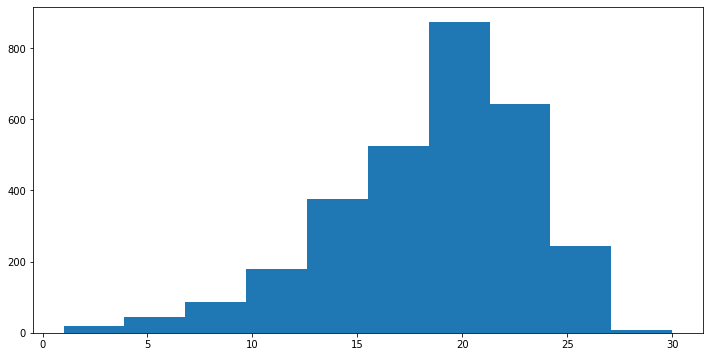

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
h1 = ax.hist(train_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 25

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((3000, 25), (1166, 25))

In [ ]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  986,   10, 1932,   11,  122, 1522,   15,  321,  550,
        119,  124,    4], dtype=int32)

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
le.fit(train_sentiments)
list(le.classes_)

['Negative', 'Positive']

In [ ]:
y_train = le.transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
print(y_train)
print(len(y_train))
print(y_test)
print(len(y_test))

[0 1 1 ... 1 1 0]
3000
[1 0 1 ... 1 1 1]
1166


Prepare the Model

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
VOCAB_SIZE

5531

In [ ]:
EMBED_SIZE = 100
EPOCHS=5
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()

model.add(Embedding(VOCAB_SIZE, 
                    EMBED_SIZE, 
                    input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 25, 100)           553100    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 25, 128)           51328     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 12, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 12, 64)            32832     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 6, 32)             8224      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 3, 32)            

Model Training

In [ ]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
history = model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
 #         callbacks=[es], 
          verbose=1)

Epoch 1/5
22/22 [==============================] - 1s 20ms/step - loss: 0.5001 - accuracy: 0.8185 - val_loss: 0.4549 - val_accuracy: 0.7867
Epoch 2/5
22/22 [==============================] - 0s 12ms/step - loss: 0.2977 - accuracy: 0.8326 - val_loss: 0.3362 - val_accuracy: 0.7867
Epoch 3/5
22/22 [==============================] - 0s 12ms/step - loss: 0.1307 - accuracy: 0.9456 - val_loss: 0.5881 - val_accuracy: 0.8967
Epoch 4/5
22/22 [==============================] - 0s 12ms/step - loss: 0.0277 - accuracy: 0.9919 - val_loss: 0.6584 - val_accuracy: 0.8767
Epoch 5/5
22/22 [==============================] - 0s 13ms/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 0.6211 - val_accuracy: 0.9200


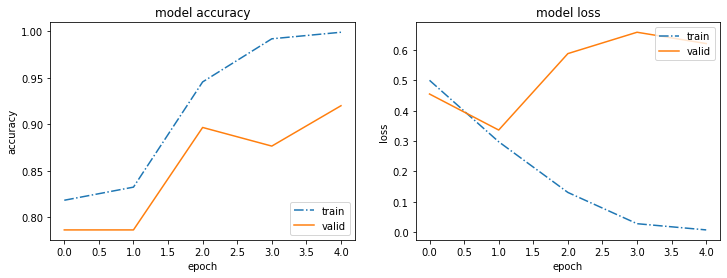

In [ ]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

Model Evaluation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 0s 3ms/step - loss: 0.9074 - accuracy: 0.8825
Accuracy: 88.25%


In [ ]:
predictions = model.predict(X_test)
predictions[200:210]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
predictions = ['Positive' if item == 1 else 'Negative' for item in predictions]
predictions[:10]

['Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive']

In [ ]:
test_sentiments

array(['Positive', 'Positive', 'Negative', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'neutral', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       224
     Neutral       0.00      0.00      0.00       856
    Positive       0.47      1.00      0.64       946

    accuracy                           0.47      2026
   macro avg       0.16      0.33      0.21      2026
weighted avg       0.22      0.47      0.30      2026



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,negative,neutral,positive
negative,0,0,224
neutral,0,0,856
positive,0,0,946
